**RGB - Greyscale conversion**

First, convert all fundus images from RGB to greyscale from both test and train folders. Train folder contains 600 fundus images and 600 ground truths (vessel locations). Test folder contains 200 fundus images and 200 ground truths (vessel locations). The goal is to find vessel locations within fundus images in test set.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#this code normalises and resize test_groudntruth and train_groundtruth images, and load them into new folders
#test_groundtruth_processed and train_groundtruth_processed.
import os
import cv2
import numpy as np

def preprocess_image(image_path, target_size=(128, 128)):
    # Load image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Unable to load image: {image_path}")
        return None

    # Normalize pixel values to [0, 1]
    image = image.astype(np.float32) / 255.0

    # Resize image
    image = cv2.resize(image, target_size)

    return image

def preprocess_images_in_folder(folder_path, target_size=(128, 128), save_folder=None):
    if save_folder and not os.path.exists(save_folder):
        os.makedirs(save_folder)

    # Iterate over files in the folder
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        # Preprocess each image
        image = preprocess_image(image_path, target_size=target_size)
        if image is not None:
            # Save preprocessed image to new folder if specified
            if save_folder:
                cv2.imwrite(os.path.join(save_folder, filename), image * 255.0)
            else:
                print("No save folder specified. Preprocessed images will not be saved.")
    print("Preprocessing completed.")

# Define paths to train and test ground truth folders
train_groundtruth_folder = '/content/drive/MyDrive/task4/train_groundtruth'
test_groundtruth_folder = '/content/drive/MyDrive/task4/test_groundtruth'

# Define paths to save processed images
train_groundtruth_processed_folder = '/content/drive/MyDrive/task4/train_groundtruth_processed'
test_groundtruth_processed_folder = '/content/drive/MyDrive/task4/test_groundtruth_processed'

# Specify target size for resizing images
target_size = (128, 128)

# Preprocess train ground truth images
preprocess_images_in_folder(train_groundtruth_folder, target_size=target_size, save_folder=train_groundtruth_processed_folder)

# Preprocess test ground truth images
preprocess_images_in_folder(test_groundtruth_folder, target_size=target_size, save_folder=test_groundtruth_processed_folder)


KeyboardInterrupt: 

**Preprossing: normalisation and resising:**

This normalises and resize test_groudntruth and train_groundtruth images, and load them into new folders test_groundtruth_processed and train_groundtruth_processed.



In [ ]:

import os
import cv2
import numpy as np

def preprocess_image(image_path, target_size=(128, 128), convert_to_grayscale=True):
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Unable to load image: {image_path}")
        return None

    if convert_to_grayscale:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Normalise pixel values to [0, 1]
    image = image.astype(np.float32) / 255.0

    # Resize image
    image = cv2.resize(image, target_size)

    return image

def preprocess_images_in_folder(folder_path, target_size=(128, 128), save_folder=None, convert_to_grayscale=True):
    if save_folder and not os.path.exists(save_folder):
        os.makedirs(save_folder)


    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        image = preprocess_image(image_path, target_size=target_size, convert_to_grayscale=convert_to_grayscale)
        if image is not None:

            if save_folder:
                cv2.imwrite(os.path.join(save_folder, filename), image * 255.0)
            else:
                print("No save folder specified. Preprocessed images will not be saved.")
    print("Preprocessing completed.")


train_original_folder = '/content/drive/MyDrive/task4/train_original'
test_original_folder = '/content/drive/MyDrive/task4/test_original'


train_processed_folder = '/content/drive/MyDrive/task4/train_original_processed'
test_processed_folder = '/content/drive/MyDrive/task4/test_original_processed'

target_size = (128, 128)


preprocess_images_in_folder(train_original_folder, target_size=target_size, save_folder=train_processed_folder, convert_to_grayscale=True)


preprocess_images_in_folder(test_original_folder, target_size=target_size, save_folder=test_processed_folder, convert_to_grayscale=True)


**Define U-Net building blocks and architecture**

This is a typical structure of U-Net (source: https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/):

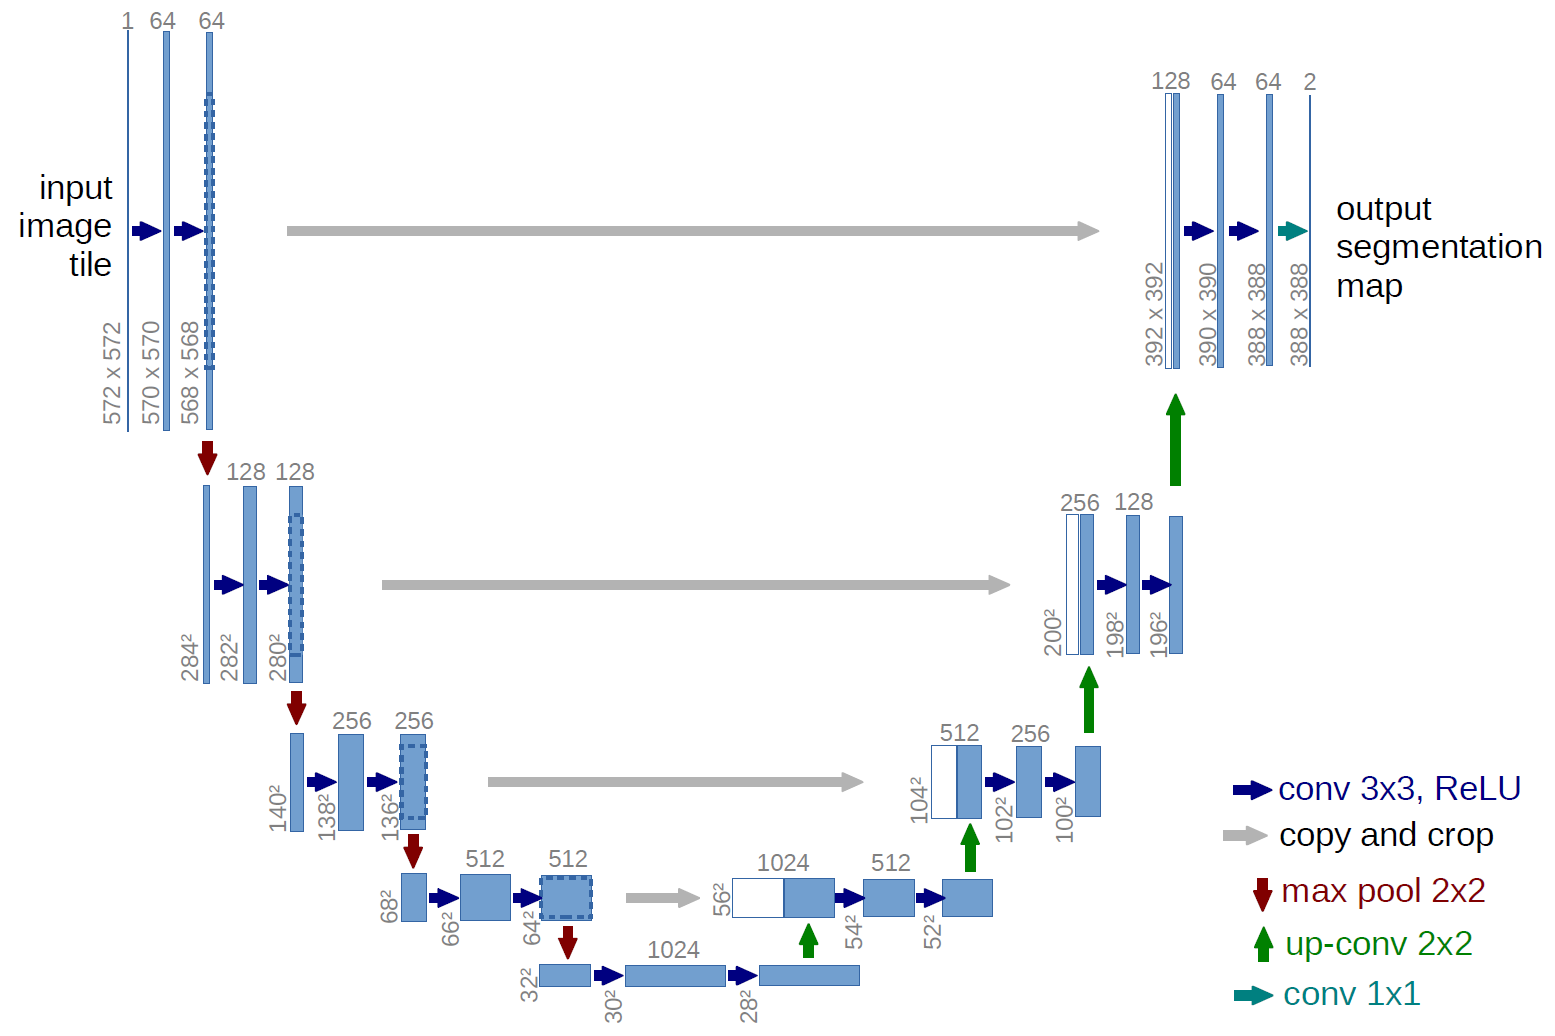

The **downsample_block(inputs, filters)** performs two convolutional operations followed by max-pooling, and the **upsample_block(inputs, filters)** performs upsampling using a transposed convolution layer. The U-Net Architecture is defined by **unet_model(input_shape, num_classes)**, which consists of an Encoder, Bottlenec, Decoder and Output layer.

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers

def downsample_block(inputs, filters):
    # Convolutional layers
    conv1 = layers.Conv2D(filters, kernel_size=3, activation='relu', padding='same')(inputs)
    conv2 = layers.Conv2D(filters, kernel_size=3, activation='relu', padding='same')(conv1)

    # Max pooling layer for downsampling
    pool = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    return conv2, pool

def upsample_block(inputs, skip_connections, filters):
    # Upsampling layer
    upsample = layers.Conv2DTranspose(filters, kernel_size=2, strides=2, padding='same')(inputs)

    # Concatenate with skip connections from the encoder
    concat = layers.concatenate([upsample, skip_connections], axis=-1)

    # Convolutional layers
    conv1 = layers.Conv2D(filters, kernel_size=3, activation='relu', padding='same')(concat)
    conv2 = layers.Conv2D(filters, kernel_size=3, activation='relu', padding='same')(conv1)

    return conv2

def unet_model(input_shape, num_classes):
    # Input layer
    inputs = layers.Input(shape=input_shape)

    # Encoder (Downsample)
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)


    # Bottleneck
    bottleneck = layers.Conv2D(1024, kernel_size=3, activation='relu', padding='same')(p4)
    bottleneck = layers.Conv2D(1024, kernel_size=3, activation='relu', padding='same')(bottleneck)

    # Decoder (Upsample)
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)

    # Output layer
    outputs = layers.Conv2D(num_classes, kernel_size=1, activation='sigmoid')(u9)  # Sigmoid activation for binary segmentation

    # Define model
    model = tf.keras.Model(inputs, outputs, name="U-Net")
    return model

# Define paths to the processed train data directories
train_images_dir = '/content/drive/MyDrive/task4/train_original_processed'
train_masks_dir = '/content/drive/MyDrive/task4/train_groundtruth_processed'

# Load train images
train_images = []
for filename in sorted(os.listdir(train_images_dir)):
    image_path = os.path.join(train_images_dir, filename)
    image = tf.keras.preprocessing.image.load_img(image_path, color_mode='grayscale')
    image = tf.keras.preprocessing.image.img_to_array(image) / 255.0  # Normalize pixel values
    train_images.append(image)
train_images = np.array(train_images)

# Load train masks
train_masks = []
for filename in sorted(os.listdir(train_masks_dir)):
    mask_path = os.path.join(train_masks_dir, filename)
    mask = tf.keras.preprocessing.image.load_img(mask_path, color_mode='grayscale')
    mask = tf.keras.preprocessing.image.img_to_array(mask) / 255.0  # Normalize pixel values
    train_masks.append(mask)
train_masks = np.array(train_masks)




In [ ]:
train_masks.shape


(598, 128, 128, 1)

**Model training and evaluation**

When the model is compiled, the Adam Optimiser is used for effective gradient-based optimisation. Binary cross-entropy is chosen for this, as it is a binary segemation task.

To assess the model performance on the validation set, the DICE similarity coefficient is used,
which compares the spatial overlap between two binary masks. Early stopping is enforced
at epoch 40 (Fig. a), where the DICE is found to be 0.935, signifying good segmentation
performance. Training beyond epoch 40 shows a plateauing of val loss, yet train loss keeps
decreasing, signalling overfitting.

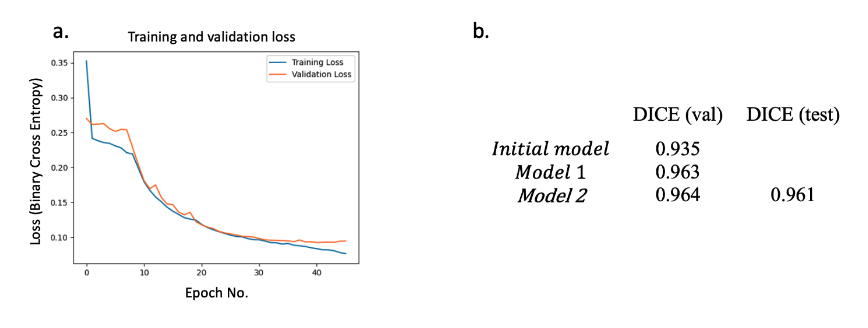

In [ ]:
# Compile the model
input_shape = train_images[0].shape
num_classes = 1  # Binary segmentation
model = unet_model(input_shape, num_classes)
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

# Define callbacks
checkpoint_path = "unet_checkpoint.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train the model
history = model.fit(train_images, train_masks, batch_size=16, epochs=50, validation_split=0.2, callbacks=[checkpoint, early_stopping])

# Plot learning curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Calculate Dice coefficient
def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Evaluate Dice coefficient on validation data
val_dice = model.evaluate(train_images, train_masks, verbose=0, batch_size=16)
print("Validation Dice Coefficient:", val_dice)

Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: 0.8898 - accuracy: 0.9127

ValueError: Data cardinality is ambiguous:
  x sizes: 120
  y sizes: 119
Make sure all arrays contain the same number of samples.

**U-Net Peformance Analysis**

The best performing model2 is selected and tested against 200 test Fundus images. Here, a
DICE score of 0.961 is observed (Fig. b from above), which equates to solid segmentation performance.
This slight dip in performance is as expected, with the possibilty of data leakage and dataset
differences. Yet, data leakage is not a major concern in image segmentation, where each image
is processed independently. From visual inspection, it is evident that the model generalises
well across test Fundus images. In comparison with the groundtruth masks, it has
managed to capture the vast majority of vessels. However, a small quantity of vessels which are
not present in the groundtruth masks are generated in the predicted masks. This is likely due to
noise within training images, or overfitting. On the other hand, the model has also managed to
captrue landmark features within the SLO image, such as the location of the retina. The genearl
location of the vessels are visible, yet the resolution is suboptimal. One tactic to optimise this in
future model training could be increasing the image size used in, hence retaining more training
information.

1/1 [==============================] - 0s 21ms/step


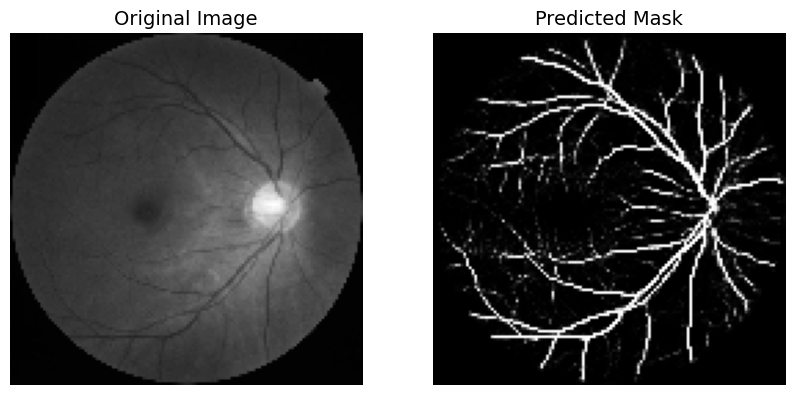

In [ ]:
#Test performance with actual images from test folder

import matplotlib.pyplot as plt
import cv2
import numpy as np

# Load the new image
image_path = '/content/drive/MyDrive/task4/test_original_processed/182_N.png'

def preprocess_image(image_path, target_size=(128, 128), convert_to_grayscale=True):
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Unable to load image: {image_path}")
        return None

    # Convert image to grayscale if specified
    if convert_to_grayscale:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Normalize pixel values to [0, 1]
    image = image.astype(np.float32) / 255.0

    # Resize image
    image = cv2.resize(image, target_size)

    # Add batch dimension
    image = np.expand_dims(image, axis=0)

    return image

# Preprocess the image
preprocessed_image = preprocess_image(image_path)

# Make predictions
predicted_mask = model.predict(preprocessed_image)

# Display the original image and the predicted mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(preprocessed_image[0], cmap='gray')
plt.title('Original Image', fontsize = '14')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask[0], cmap='gray')
plt.title('Predicted Mask',fontsize = '14')
plt.axis('off')

plt.show()



1/1 [==============================] - 1s 816ms/step


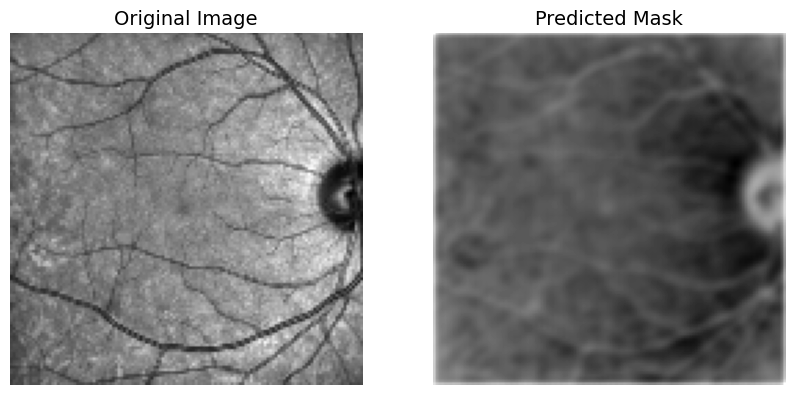

In [ ]:
#Test performance with actual images from test folder

import matplotlib.pyplot as plt
import cv2
import numpy as np

# Load the new image
image_path = '/content/drive/MyDrive/SLO copy/hc2_1.png'

def preprocess_image(image_path, target_size=(128, 128), convert_to_grayscale=True):
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Unable to load image: {image_path}")
        return None

    # Convert image to grayscale if specified
    if convert_to_grayscale:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Normalize pixel values to [0, 1]
    image = image.astype(np.float32) / 255.0

    # Resize image
    image = cv2.resize(image, target_size)

    # Add batch dimension
    image = np.expand_dims(image, axis=0)

    return image

# Preprocess the image
preprocessed_image = preprocess_image(image_path)

# Make predictions
predicted_mask = model.predict(preprocessed_image)

# Display the original image and the predicted mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(preprocessed_image[0], cmap='gray')
plt.title('Original Image', fontsize = '14')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask[0], cmap='gray')
plt.title('Predicted Mask',fontsize = '14')
plt.axis('off')

plt.show()


In [ ]:
#test performance of best performing model during training

# Define paths to the processed test data directories
test_images_dir = '/content/drive/MyDrive/task4/test_original_processed'
test_masks_dir = '/content/drive/MyDrive/task4/test_groundtruth_processed'

# Load test images
test_images = []
for filename in sorted(os.listdir(test_images_dir)):
    image_path = os.path.join(test_images_dir, filename)
    image = tf.keras.preprocessing.image.load_img(image_path, color_mode='grayscale')
    image = tf.keras.preprocessing.image.img_to_array(image) / 255.0  # Normalize pixel values
    test_images.append(image)
test_images = np.array(test_images)

# Load test masks
test_masks = []
for filename in sorted(os.listdir(test_masks_dir)):
    mask_path = os.path.join(test_masks_dir, filename)
    mask = tf.keras.preprocessing.image.load_img(mask_path, color_mode='grayscale')
    mask = tf.keras.preprocessing.image.img_to_array(mask) / 255.0  # Normalize pixel values
    test_masks.append(mask)
test_masks = np.array(test_masks)

# Evaluate the model on the test data
evaluation = model.evaluate(test_images, test_masks)
print("Test Loss:", evaluation[0])
print("Test Dice Coefficient:", evaluation[1])
